In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.linalg import sqrtm
import pandas as pd
from PIL import Image
from skimage.transform import resize

# keras packages
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, Conv2D, BatchNormalization, LeakyReLU
from keras.datasets import cifar10
from keras.initializers import RandomNormal
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [8]:
# constants and common functions
inputImageHeight, InputImageWidth = 128, 128
customKernelInitializer = RandomNormal(mean=0, stddev=0.02)

def generateNoise(dimension, samples):
    x = np.random.randn(dimension*samples)
    x =  x.reshape(samples, dimension)
    return x

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        new_image = resize(image, new_shape, 0)    # resize with nearest neighbor interpolation
        images_list.append(new_image) # store
    return np.asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(images1, images2):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar
def smooth(scalars, weight) :  # Weight between 0 and 1
    if not scalars: return
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed
  
# https://realpython.com/python-csv/
def plotGraph(filename, smoothingFactor):
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        graph = []
        for row in csv_reader:
            for column in row:
                graph.append(float(column))
    graph = smooth(graph, smoothingFactor)
    plt.plot(graph)
    return

def calculate_fidLarge(modelToTest, totalImages, numberOfImagesPerIteration, testSet):
    numberOfIterations = int(totalImages/numberOfImagesPerIteration)
    generationActs = []
    testActs = []
#     print(numberOfIterations)
    for i in range(numberOfIterations):
        print(i)
        generatedImage = modelToTest.predict(np.random.normal(0, 1, (numberOfImagesPerIteration, 150)))
        testImages = np.array([(np.array(Image.open(i))/127.5) - 1 for i in np.random.choice(testSet, numberOfImagesPerIteration, replace = False)])
        model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
        images1 = generatedImage.astype('float32')
        images2 = testImages.astype('float32')
        images1 = scale_images(images1, (299,299,3))
        images2 = scale_images(images2, (299,299,3))
        # calculate activations
        act1 = model.predict(images1)
        for act in act1:
            generationActs.append(act)
        act2 = model.predict(images2)
        for act in act2:
            testActs.append(act)
    generationActs = np.array(generationActs)
    testActs = np.array(testActs)
    # calculate mean and covariance statistics
    mu1, sigma1 = generationActs.mean(axis=0), np.cov(generationActs, rowvar=False)
    mu2, sigma2 = testActs.mean(axis=0), np.cov(testActs, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

Generator & Discriminator

In [3]:
def DCGANGenerator():
    noise = Input((150,), name='generatorInput')
    # Dense first layer
    firstLayer = Dense(4*4*1024, activation='relu', name='generatorDenseLayer', kernel_initializer=customKernelInitializer)(noise)
    firstLayer = Reshape((4,4,1024))(firstLayer)
    # ConvT Transpose second Layer
    secondLayer = Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu', name='generatorConvTLayer1', kernel_initializer=customKernelInitializer)(firstLayer) # 8x8
    secondLayer = BatchNormalization(name='generatorBatchNormalization1',epsilon=0.00002)(secondLayer)
    # ConvT Transpose third Layer
    thirdLayer = Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu', name='generatorConvTLayer2', kernel_initializer=customKernelInitializer)(secondLayer) # 16x16
    thirdLayer = BatchNormalization(name='generatorBatchNormalization2',epsilon=0.00002)(thirdLayer)
    # ConvT Transpose fourth Layer
    fourthLayer = Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu', name='generatorConvTLayer3', kernel_initializer=customKernelInitializer)(thirdLayer) # 32x32
    fourthLayer = BatchNormalization(name='generatorBatchNormalization3',epsilon=0.00002)(fourthLayer)
    # ConvT Transpose fifth Layer
    fifthLayer = Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu', name='generatorConvTLayer4', kernel_initializer=customKernelInitializer)(fourthLayer) # 64x64
    fifthLayer = BatchNormalization(name='generatorBatchNormalization4',epsilon=0.00002)(fifthLayer)
    # ConvT Transpose sixth Layer
    sixthLayer = Conv2DTranspose(32, 4, strides=2, padding='same', activation='relu', name='generatorConvTLayer5', kernel_initializer=customKernelInitializer)(fifthLayer) # 128x128
    sixthLayer = BatchNormalization(name='generatorBatchNormalization5',epsilon=0.00002)(sixthLayer)

    # Conv Transpose Layer
    seventhLayer = Conv2D(3, 4, padding='same', activation='tanh', name='generatorLayer6', kernel_initializer=customKernelInitializer)(sixthLayer) # 128x128
    return Model(noise, seventhLayer)

def DCGANDiscriminator():
    image = Input((inputImageHeight, InputImageWidth, 3))
    # first convolutional layer
    firstLayer = Conv2D(32, 4, strides = 2, padding='same', name='discriminatorLayer1', kernel_initializer=customKernelInitializer)(image) # 64x64
    firstLayer = LeakyReLU(alpha=0.2)(firstLayer)

    # second convolutional layer
    secondLayer = Conv2D(64, 4, strides=2, padding='same', name='discriminatorLayer2', kernel_initializer=customKernelInitializer)(firstLayer) # 32x32
    secondLayer = BatchNormalization(name='discriminatorBatchNormalization1',epsilon=0.00002)(secondLayer)
    secondLayer = LeakyReLU(alpha=0.2)(secondLayer)

    # third convolutional layer
    thirdLayer = Conv2D(128, 4, strides=2, padding='same', name='discriminatorLayer3', kernel_initializer=customKernelInitializer)(secondLayer) # 16x16
    thirdLayer = BatchNormalization(name='discriminatorBatchNormalization2',epsilon=0.00002)(thirdLayer)
    thirdLayer = LeakyReLU(alpha=0.2)(thirdLayer)

    # fourth convolutional layer
    fourthLayer = Conv2D(256, 4, strides = 2, padding='same', name='discriminatorLayer4', kernel_initializer=customKernelInitializer)(thirdLayer) # 8x8
    fourthLayer = BatchNormalization(name='discriminatorBatchNormalization3',epsilon=0.00002)(fourthLayer)
    fourthLayer = LeakyReLU(alpha=0.2)(fourthLayer)

    # fifth convolutional layer
    fifthLayer = Conv2D(256, 4, strides = 2, padding='same', name='discriminatorLayer5', kernel_initializer=customKernelInitializer)(fourthLayer) # 4x4
    fifthLayer = BatchNormalization(name='discriminatorBatchNormalization4',epsilon=0.00002)(fifthLayer)
    fifthLayer = LeakyReLU(alpha=0.2)(fifthLayer)

    # sixth convolutional layer
    sixthLayer = Conv2D(256, 4, strides = 2, padding='same', name='discriminatorLayer6', kernel_initializer=customKernelInitializer)(fifthLayer) # 2x2
    sixthLayer = BatchNormalization(name='discriminatorBatchNormalization5',epsilon=0.00002)(sixthLayer)
    sixthLayer = LeakyReLU(alpha=0.2)(sixthLayer)

    # seventh convolutional layer
    seventhLayer = Flatten()(sixthLayer)
    seventhLayer = Dense(1, activation='sigmoid', name='discriminatorDenseLayer', kernel_initializer=customKernelInitializer)(seventhLayer)
    return Model(input = image, output=seventhLayer)

In [4]:
generatorDCGan = DCGANGenerator()
discriminatorDCGan = DCGANDiscriminator()
discriminatorDCGan.compile(loss='binary_crossentropy', optimizer=Adam(6e-6, beta_1=0.5), metrics=['accuracy'])
generatorDCGan.summary()
discriminatorDCGan.summary()








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generatorInput (InputLayer)  (None, 150)               0         
_________________________________________________________________
generatorDenseLayer (Dense)  (None, 16384)             2473984   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
generatorConvTLayer1 (Conv2D (None, 8, 8, 512)         8389120   
_________________________________________________________________
generatorBatchNormalization1 (None, 8, 8, 512)         2048      
_________________________________________________________________
generatorConvTLayer2 (Conv2D (None, 16, 16, 256)       2097408   
_________________________________________

D:\Anaconda\envs\KerasGPU\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("di...)`


Creating DCGAN & loading models

In [5]:
def createDCGan(generatorDCGan, discriminatorDCGan):
    noise = Input((150,))
    image =  Input((inputImageHeight, InputImageWidth, 3))
    generatorImage = generatorDCGan(noise)
    discriminatorDCGan.trainable = False
    discriminatorOutput = discriminatorDCGan(generatorImage)
    return Model(noise,outputs=discriminatorOutput)

# load models
discriminatorDCGan = load_model('DCGanDisc_model.h5')
generatorDCGan = load_model('DCGanGen_model.h5')

combined_model = createDCGan(generatorDCGan, discriminatorDCGan)
combined_model.summary()
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(2e-4, beta_1=0.5), metrics=['accuracy'])

D:\Anaconda\envs\KerasGPU\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150)               0         
_________________________________________________________________
model_1 (Model)              (None, 128, 128, 3)       13654371  
_________________________________________________________________
model_2 (Model)              (None, 1)                 2792673   
Total params: 16,447,044
Trainable params: 13,652,387
Non-trainable params: 2,794,657
_________________________________________________________________


Load dataset

In [ ]:
trainSet = pd.read_csv('dataset/train.csv', header=None).to_numpy()
trainSet = trainSet.reshape(len(trainSet),)
testSet = pd.read_csv('dataset/test.csv', header=None).to_numpy()
testSet = testSet.reshape(len(testSet),)

def dataGenerator(data, batchSize):
    while True:
        imageBatch = np.random.choice(data, batchSize, replace = False)
        images = []
        for image in imageBatch:
            folderName = 'thumbnails/'
            image = folderName + image.split('/')[-1]
            images.append((np.array(Image.open(image))/127.5) - 1)
        yield np.array(images)
    
_, axs = plt.subplots(2, 1, figsize=(10, 10))
for i, d in enumerate(dataGenerator(trainSet, 1)):  
    axs[i].imshow(d[0]*0.5+0.5)
    if(i == 1):
        break

Training Code

In [ ]:
%%time
# Training DC GAN
batch_size = 32
iteration = 1750
epochs = 10
discriminatorLossArray, DCGanGeneratorLoss, discriminatorAccuracy, DCGanGeneratorAccuracy = [], [], [], []

real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
noiseInputTest = generateNoise(150, 1)
for epoch in range(epochs):
    for i, d in enumerate(dataGenerator(trainSet, batch_size)):
        noiseInput = generateNoise(150, batch_size)
        generatedImage = generatorDCGan.predict(noiseInput)
        
        discriminatorLossReal = discriminatorDCGan.train_on_batch(d, real)
        discriminatorLossFake = discriminatorDCGan.train_on_batch(generatedImage, fake)
        discriminatorLoss = 0.5* np.add(discriminatorLossReal , discriminatorLossFake)
        discriminatorLossArray.append(discriminatorLoss[0])
        # discriminatorAccuracy.append(100*discriminatorLoss[1])
        
        noiseInput = generateNoise(150, batch_size)
        DCGan_loss = combined_model.train_on_batch(noiseInput, real)
        DCGanGeneratorLoss.append(DCGan_loss[0])
        # DCGanGeneratorAccuracy.append(100*DCGan_loss[1])
        if(i%10 == 0):
            print("Epoch %d/%d   iteration %d/%d  D Acc %3d%%  D Loss: %f  DCGAN Loss: %f" % 
                  (epoch+1, epochs, i, iteration, 100*discriminatorLoss[1], discriminatorLoss[0], DCGan_loss[0]))
            
        if(i == iteration-1):
            break
    if (epoch+1) % 2 == 0:
        generatedImage = generatorDCGan.predict(generateNoise(150, 100))
        fid = calculate_fid(generatedImage, np.array([(np.array(Image.open(i))/127.5) - 1 for i in np.random.choice(testSet, 100, replace = False)]))
        print('FID : %.3f' % fid)
        with open('discriminatorLossFile.csv', mode='a') as discriminatorLossFile:
            discriminatorLossFile_writer = csv.writer(discriminatorLossFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            discriminatorLossFile_writer.writerow(discriminatorLossArray)
            discriminatorLossArray = []
        with open('DCGanLossFile.csv', mode='a') as DCGanLossFile:
            DCGanLossFile_writer = csv.writer(DCGanLossFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            DCGanLossFile_writer.writerow(DCGanGeneratorLoss)
            DCGanGeneratorLoss = []
        with open('FIDScore.csv', mode='a') as FIDScoreFile:
            FIDScoreFileFile_writer = csv.writer(FIDScoreFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            FIDScoreFileFile_writer.writerow([fid])
        generatorDCGan.save('DCGanGen_model.h5')
        discriminatorDCGan.save('DCGanDisc_model.h5')

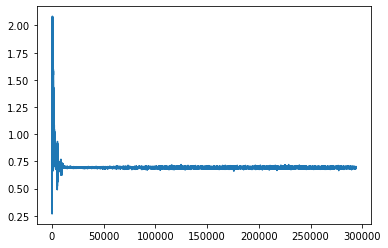

In [12]:
plotGraph('discriminatorLossFile.csv', 0)

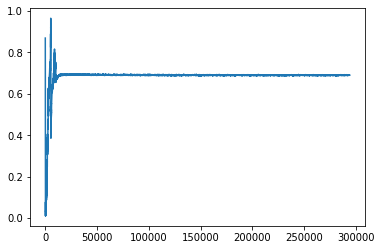

In [14]:
plotGraph('DCGanLossFile.csv', 0.95)

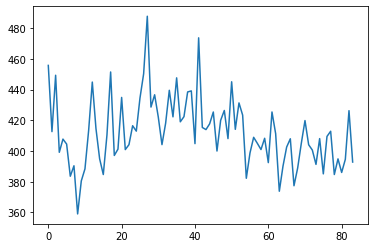

In [15]:
plotGraph('FIDScore.csv', 0)

In [ ]:
%%time
fid = calculate_fidLarge(generator, 10000, 1000, testSet)
print('FID: '+str(fid))

Show generated Images

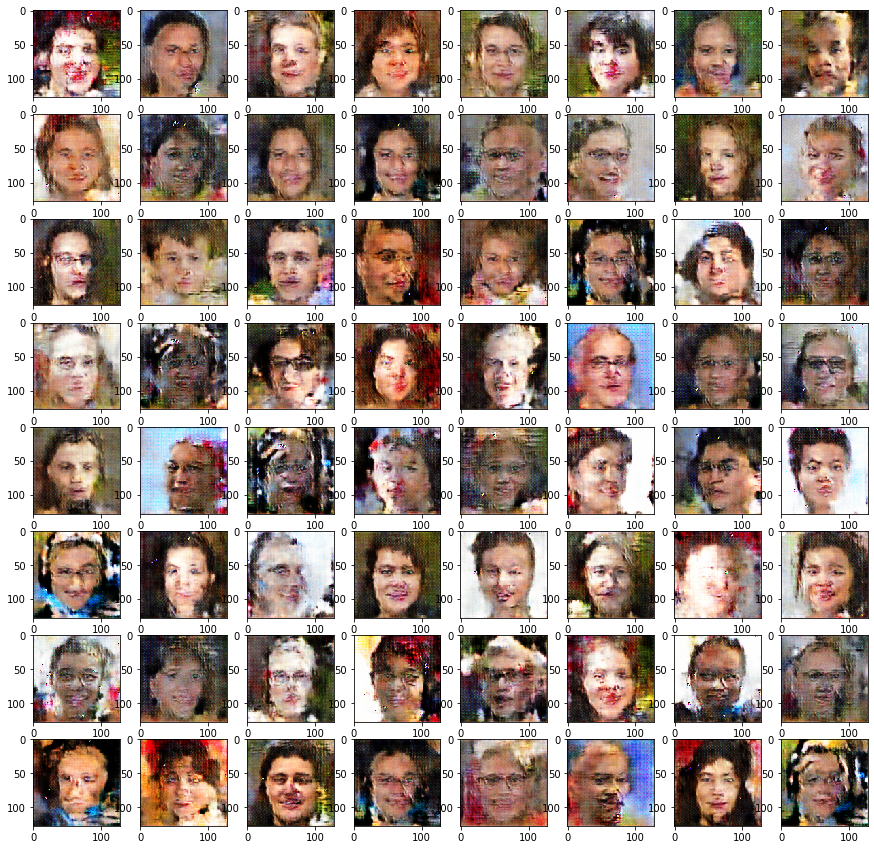

In [18]:
_, axs = plt.subplots(8, 8, figsize=(15, 15))

noiseInputTest = np.random.normal(0, 1, (64, 150))
# noiseInputTest[0][23] = 0.1
generatedImage = generatorDCGan.predict(noiseInputTest)
generatedImage = (generatedImage*0.5 + 0.5).reshape(64,128, 128, 3)
for i in range(8):
    for j in range(8):
        axs[i][j].imshow(generatedImage[i*8+j])